In [ ]:
!pip install -q transformers datasets accelerate einops scikit-learn

In [ ]:
from datasets import load_dataset


In [ ]:
pip install -U datasets

In [ ]:
streamed_dataset = load_dataset("ag_news", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
texts = [x["text"] for x in streamed_dataset if len(x["text"].split()) > 10]

print(f"Loaded {len(texts)} clean samples")
print(texts[0][:300])

Loaded 119985 clean samples
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Automatically detect GPU if available, else fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

small_id = "EleutherAI/pythia-410m"
large_id = "EleutherAI/pythia-1.4b"

tokenizer = AutoTokenizer.from_pretrained(small_id)
tokenizer.pad_token = tokenizer.eos_token  # Important for padding masking

# Load models to the right device and set eval mode
small_model = AutoModelForCausalLM.from_pretrained(small_id).to(device).eval()
large_model = AutoModelForCausalLM.from_pretrained(large_id).to(device).eval()


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

In [ ]:
import torch.nn.functional as F

def compute_entropy(probs):
    return -(probs * probs.log()).sum(dim=-1)

def get_entropy_for_prompt(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True).to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = F.softmax(logits, dim=-1)
        entropies = compute_entropy(probs)
    return entropies[0, 1:], inputs["input_ids"][0][1:]  # Skip first token


In [ ]:
results = []

for text in texts[:1000]:  # limit to avoid OOM
    try:
        # Tokenize and move inputs to GPU
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)

        with torch.no_grad():
            # Get model outputs (on GPU)
            s_logits = small_model(**inputs).logits[0]  # shape: [T, V]
            l_logits = large_model(**inputs).logits[0]

            # Compute probabilities and entropies (still on GPU)
            s_probs = F.softmax(s_logits, dim=-1)
            l_probs = F.softmax(l_logits, dim=-1)

            s_entropy = compute_entropy(s_probs)  # shape: [T]
            l_entropy = compute_entropy(l_probs)

            # Top-5 logits from the small model
            topk = torch.topk(s_logits, k=5, dim=-1).values  # shape: [T, 5]

        # Retrieve and trim input_ids (on GPU still)
        input_ids = inputs["input_ids"][0]

        # Align all tensors to minimum sequence length
        min_len = min(len(s_entropy), len(l_entropy), len(input_ids))
        s_entropy = s_entropy[:min_len].cpu()
        l_entropy = l_entropy[:min_len].cpu()
        topk = topk[:min_len].cpu()
        input_ids = input_ids[:min_len].cpu()

        # Convert to tokens (CPU)
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        # Create labels and residuals (Python list of floats)
        label = [int(s > 2.0 and l < 1.0) for s, l in zip(s_entropy, l_entropy)]
        residual = [(l - s).item() for s, l in zip(s_entropy, l_entropy)]

        # Store the processed result
        results.append({
            "text": text,
            "tokens": tokens,
            "input_ids": input_ids.tolist(),
            "se": s_entropy.tolist(),
            "le": l_entropy.tolist(),
            "logits_topk": topk.tolist(),
            "label": label,
            "residual": residual
        })

    except Exception as e:
        print("⚠️ Skipping due to:", e)




In [ ]:
import json

with open("entropy_supervised_dataset.jsonl", "w") as f:
    for ex in results:
        json.dump(ex, f)
        f.write("\n")


In [ ]:
import json

results = []
with open("entropy_supervised_dataset.jsonl", "r") as f:
    for line in f:
        results.append(json.loads(line))

In [ ]:
class IOEpistemicDataset(Dataset):
    def __init__(self, tokenizer, results):
        self.data = []
        for ex in results:
            for i in range(len(ex["input_ids"])):
                tok_id = ex["input_ids"][i]
                topk_logits = ex["logits_topk"][i]  # list of 5 floats
                label = ex["label"][i]
                residual = ex["residual"][i]

                if tok_id >= tokenizer.vocab_size or tok_id < 0:
                    continue

                self.data.append((
                    tok_id,
                    torch.tensor(topk_logits, dtype=torch.float),
                    torch.tensor(label, dtype=torch.float),     # for classification
                    torch.tensor(residual, dtype=torch.float)   # for regression
                ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
class IOEntropyMLP(nn.Module):
    def __init__(self, vocab_size, topk_dim=5, embed_dim=32):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim + topk_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # regression or binary classification
        )

    def forward(self, tok_ids, topk_logits):
        e = self.embed(tok_ids)              # [B, D]
        x = torch.cat([e, topk_logits], dim=-1)  # [B, D+5]
        return self.mlp(x).squeeze(-1)


In [ ]:
dataset = IOEpistemicDataset(tokenizer, results)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = IOEntropyMLP(tokenizer.vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(30):
    total_loss = 0
    for tok_ids, topk_logits, labels, residuals in loader:
        tok_ids = tok_ids
        topk_logits = topk_logits
        targets = residuals # or use labels for classification

        preds = model(tok_ids, topk_logits)

        loss = F.mse_loss(preds, targets)
        # Or use BCEWithLogitsLoss if you're doing binary classification

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(loader):.4f}")


Epoch 1 | Loss: 0.6145
Epoch 2 | Loss: 0.5929
Epoch 3 | Loss: 0.5750
Epoch 4 | Loss: 0.5572
Epoch 5 | Loss: 0.5408
Epoch 6 | Loss: 0.5265
Epoch 7 | Loss: 0.5144
Epoch 8 | Loss: 0.5032
Epoch 9 | Loss: 0.4941
Epoch 10 | Loss: 0.4867
Epoch 11 | Loss: 0.4799
Epoch 12 | Loss: 0.4753
Epoch 13 | Loss: 0.4703
Epoch 14 | Loss: 0.4665
Epoch 15 | Loss: 0.4628
Epoch 16 | Loss: 0.4598
Epoch 17 | Loss: 0.4572
Epoch 18 | Loss: 0.4542
Epoch 19 | Loss: 0.4575
Epoch 20 | Loss: 0.4505
Epoch 21 | Loss: 0.4499
Epoch 22 | Loss: 0.4473
Epoch 23 | Loss: 0.4463
Epoch 24 | Loss: 0.4453
Epoch 25 | Loss: 0.4439
Epoch 26 | Loss: 0.4427
Epoch 27 | Loss: 0.4410
Epoch 28 | Loss: 0.4402
Epoch 29 | Loss: 0.4389
Epoch 30 | Loss: 0.4381


In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Switch model to evaluation mode
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for tok_ids, topk_logits, labels, residuals in loader:
        tok_ids = tok_ids.to(device)
        topk_logits = topk_logits.to(device)
        targets = residuals.to(device)

        preds = model(tok_ids, topk_logits)

        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

# Metrics
mse = mean_squared_error(all_targets, all_preds)
rmse = mse ** 0.5
pearson_r, _ = pearsonr(all_targets, all_preds)

print(f"\nEvaluation:")
print(f"MSE     : {mse:.4f}")
print(f"RMSE    : {rmse:.4f}")
print(f"Pearson : {pearson_r:.4f}")



Evaluation:
MSE     : 0.4241
RMSE    : 0.6512
Pearson : 0.5671


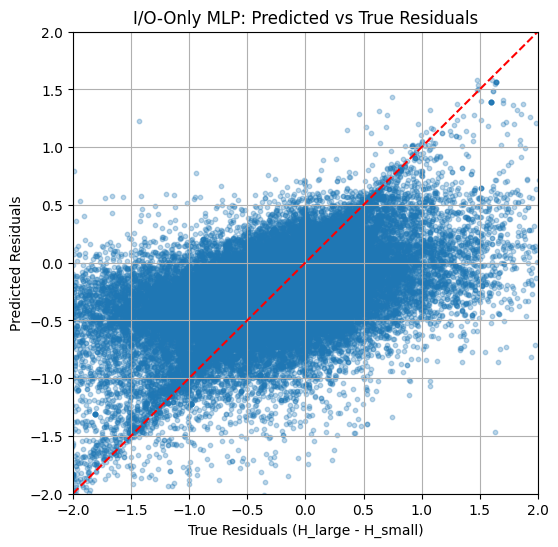

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.3, s=10)
plt.xlabel("True Residuals (H_large - H_small)")
plt.ylabel("Predicted Residuals")
plt.title("I/O-Only MLP: Predicted vs True Residuals")
plt.grid(True)
plt.plot([-2, 2], [-2, 2], 'r--')  # Diagonal reference
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()


In [ ]:
from tqdm import tqdm

for ex in tqdm(results):
    try:
        # Re-tokenize text
        inputs = tokenizer(ex["text"], return_tensors="pt", truncation=True, max_length=128, padding=True)

        with torch.no_grad():
            outputs = small_model(**inputs, output_hidden_states=True)
            # Get last hidden layer: [1, T, H]
            hidden = outputs.hidden_states[-1][0]  # shape [T, hidden_dim]

        input_ids = inputs["input_ids"][0]
        min_len = min(len(input_ids), len(hidden), len(ex["residual"]))  # align with previously stored values

        ex["hidden_states"] = hidden[:min_len].cpu().tolist()

    except Exception as e:
        print("⚠️ Skipping due to:", e)


100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]


In [ ]:
class HiddenStateDataset(Dataset):
    def __init__(self, results):
        self.data = []

        for ex in results:
            for i in range(len(ex["hidden_states"])):
                h = ex["hidden_states"][i]
                residual = ex["residual"][i]

                # === Robustness Checks ===
                if not isinstance(h, list) or len(h) == 0:
                    continue  # Skip malformed hidden state

                if not all(isinstance(v, (float, int)) for v in h):
                    continue  # Skip non-numeric vectors

                if not isinstance(residual, (float, int)):
                    continue  # Skip invalid residuals

                # === Safe Append ===
                self.data.append((
                    torch.tensor(h, dtype=torch.float),
                    torch.tensor(residual, dtype=torch.float)
                ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
class HiddenStateMLP(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.mlp(x).squeeze(-1)


In [ ]:
hidden_dim = len(results[0]["hidden_states"][0])  # infer from 1st example

dataset_h = HiddenStateDataset(results)
loader_h = DataLoader(dataset_h, batch_size=32, shuffle=True)

model_h = HiddenStateMLP(hidden_dim).to(device)
optimizer_h = torch.optim.Adam(model_h.parameters(), lr=1e-3)

for epoch in range(30):
    total_loss = 0
    model_h.train()
    for h_vecs, targets in loader_h:
        h_vecs = h_vecs.to(device)
        targets = targets.to(device)

        preds = model_h(h_vecs)
        loss = F.mse_loss(preds, targets)

        optimizer_h.zero_grad()
        loss.backward()
        optimizer_h.step()
        total_loss += loss.item()

    print(f"[Hidden MLP] Epoch {epoch+1} | Loss: {total_loss / len(loader_h):.4f}")


[Hidden MLP] Epoch 1 | Loss: 0.5997
[Hidden MLP] Epoch 2 | Loss: 0.5505
[Hidden MLP] Epoch 3 | Loss: 0.5196
[Hidden MLP] Epoch 4 | Loss: 0.4905
[Hidden MLP] Epoch 5 | Loss: 0.4637
[Hidden MLP] Epoch 6 | Loss: 0.4385
[Hidden MLP] Epoch 7 | Loss: 0.4142
[Hidden MLP] Epoch 8 | Loss: 0.3967
[Hidden MLP] Epoch 9 | Loss: 0.3777
[Hidden MLP] Epoch 10 | Loss: 0.3634
[Hidden MLP] Epoch 11 | Loss: 0.3500
[Hidden MLP] Epoch 12 | Loss: 0.3346
[Hidden MLP] Epoch 13 | Loss: 0.3251
[Hidden MLP] Epoch 14 | Loss: 0.3135
[Hidden MLP] Epoch 15 | Loss: 0.3048
[Hidden MLP] Epoch 16 | Loss: 0.2961
[Hidden MLP] Epoch 17 | Loss: 0.2877
[Hidden MLP] Epoch 18 | Loss: 0.2801
[Hidden MLP] Epoch 19 | Loss: 0.2735
[Hidden MLP] Epoch 20 | Loss: 0.2653
[Hidden MLP] Epoch 21 | Loss: 0.2599
[Hidden MLP] Epoch 22 | Loss: 0.2561
[Hidden MLP] Epoch 23 | Loss: 0.2502
[Hidden MLP] Epoch 24 | Loss: 0.2474
[Hidden MLP] Epoch 25 | Loss: 0.2427
[Hidden MLP] Epoch 26 | Loss: 0.2397
[Hidden MLP] Epoch 27 | Loss: 0.2338
[Hidden ML

In [ ]:
model_h.eval()
all_preds_h = []
all_targets_h = []

with torch.no_grad():
    for h_vecs, targets in loader_h:
        h_vecs = h_vecs.to(device)
        targets = targets.to(device)

        preds = model_h(h_vecs)

        all_preds_h.extend(preds.cpu().tolist())
        all_targets_h.extend(targets.cpu().tolist())



In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

def evaluate_preds(preds, targets, label):
    mse = mean_squared_error(targets, preds)
    rmse = mse ** 0.5
    r, _ = pearsonr(targets, preds)
    print(f"{label} — MSE: {mse:.4f}, RMSE: {rmse:.4f}, Pearson r: {r:.4f}")
    return mse, rmse, r



In [ ]:
evaluate_preds(all_preds, all_targets, "I/O-only MLP")
evaluate_preds(all_preds_h, all_targets_h, "Hidden-State MLP")



I/O-only MLP — MSE: 0.4241, RMSE: 0.6512, Pearson r: 0.5671
Hidden-State MLP — MSE: 0.2095, RMSE: 0.4577, Pearson r: 0.8176


(0.20952566233944842, 0.4577397320961426, np.float64(0.8175806067462762))

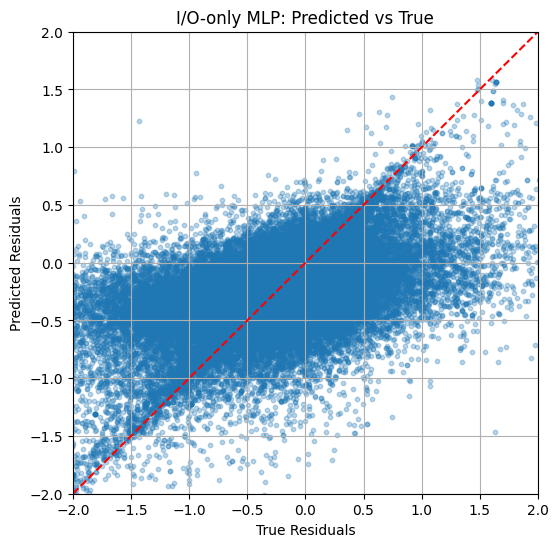

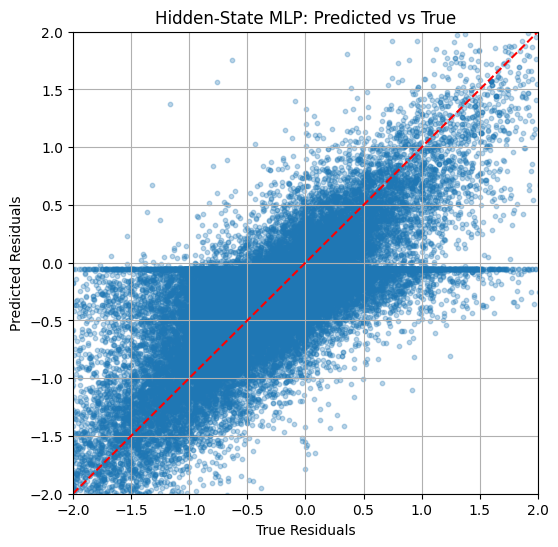

In [ ]:
def scatter_plot(true, pred, label):
    plt.figure(figsize=(6, 6))
    plt.scatter(true, pred, alpha=0.3, s=10)
    plt.xlabel("True Residuals")
    plt.ylabel("Predicted Residuals")
    plt.title(f"{label}: Predicted vs True")
    plt.plot([-2, 2], [-2, 2], 'r--')
    plt.grid(True)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.show()

scatter_plot(all_targets, all_preds, "I/O-only MLP")
scatter_plot(all_targets_h, all_preds_h, "Hidden-State MLP")


I/O-only MLP — MSE: 0.4241, RMSE: 0.6512, Pearson r: 0.5671
Hidden-State MLP — MSE: 0.2095, RMSE: 0.4577, Pearson r: 0.8176


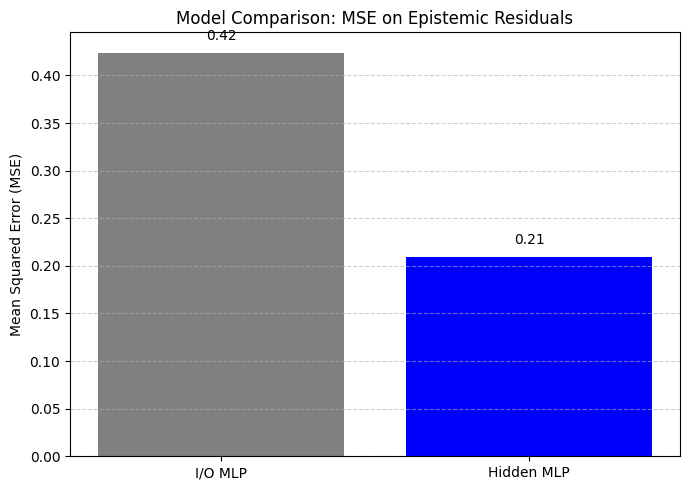

In [ ]:
mse_io, _, _ = evaluate_preds(all_preds, all_targets, "I/O-only MLP")
mse_h, _, _ = evaluate_preds(all_preds_h, all_targets_h, "Hidden-State MLP")

models = ["I/O MLP", "Hidden MLP"]
mse_values = [mse_io, mse_h]

plt.figure(figsize=(7, 5))
bars = plt.bar(models, mse_values, color=["gray", "blue"])
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Model Comparison: MSE on Epistemic Residuals")
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
def analyze_token_predictions_batch(results, model_io, model_hid, example_indices=None):
    if example_indices is None:
        example_indices = list(range(10))  # Default: first 10 examples

    vocab_size = model_io.embed.num_embeddings
    all_rows = []

    for idx in example_indices:
        ex = results[idx]

        for i in range(len(ex["tokens"])):
            tok_id = ex["input_ids"][i]
            if not (0 <= tok_id < vocab_size):
                continue

            tok = ex["tokens"][i]
            se = ex["se"][i]
            le = ex["le"][i]
            true_res = le - se
            label = ex["label"][i]
            logits_topk = torch.tensor(ex["logits_topk"][i]).unsqueeze(0)
            hidden_state = torch.tensor(ex["hidden_states"][i]).unsqueeze(0)
            tok_id_tensor = torch.tensor([tok_id])

            with torch.no_grad():
                pred_io = model_io(tok_id_tensor, logits_topk).item()
                pred_hid = model_hid(hidden_state).item()

            err_io = abs(pred_io - true_res)
            err_hid = abs(pred_hid - true_res)
            closer = "I/O" if err_io < err_hid else "Hidden"

            all_rows.append({
                "Example": idx,
                "Token": tok,
                "Label": label,
                "SE": round(se, 2),
                "LE": round(le, 2),
                "TrueRes": round(true_res, 2),
                "IO_MLP": round(pred_io, 2),
                "Hidden_MLP": round(pred_hid, 2),
                "Err_IO": round(err_io, 2),
                "Err_HID": round(err_hid, 2),
                "Closer": closer
            })

    df = pd.DataFrame(all_rows)

    # Group-level summary
    for group_label in [0, 1]:
        group = df[df["Label"] == group_label]
        print(f"\nGroup: Label = {group_label}")
        print(f"Tokens: {len(group)}")
        print(f"Avg True Residual: {group['TrueRes'].mean():.3f}")
        print(f"Avg I/O Error     : {group['Err_IO'].mean():.3f}")
        print(f"Avg Hidden Error  : {group['Err_HID'].mean():.3f}")
        io_better = (group['Err_IO'] < group['Err_HID']).mean() * 100
        print(f"% Tokens where I/O better: {io_better:.1f}%")

    # Pearson over all
    try:
        pearson_io = pearsonr(df["TrueRes"], df["IO_MLP"])[0]
        pearson_hid = pearsonr(df["TrueRes"], df["Hidden_MLP"])[0]
        print(f"\nPearson r (IO):     {pearson_io:.3f}")
        print(f"Pearson r (Hidden): {pearson_hid:.3f}")
    except Exception as e:
        print(f"Pearson calc failed: {e}")

    return df




In [ ]:
# Compare across first 20 examples
df_long = analyze_token_predictions_batch(results, model, model_h, example_indices=range(20))

# View part of the table
df_long.head(20)  # or df_long[df_long['Label'] == 1] for epistemic cases



Group: Label = 0
Tokens: 1028
Avg True Residual: -0.276
Avg I/O Error     : 0.427
Avg Hidden Error  : 0.334
% Tokens where I/O better: 46.1%

Group: Label = 1
Tokens: 17
Avg True Residual: -2.391
Avg I/O Error     : 1.485
Avg Hidden Error  : 0.401
% Tokens where I/O better: 11.8%

Pearson r (IO):     0.557
Pearson r (Hidden): 0.816


,Example,Token,Label,SE,LE,TrueRes,IO_MLP,Hidden_MLP,Err_IO,Err_HID,Closer
0,0,Wall,0,7.18,5.15,-2.03,-1.90,-1.65,0.13,0.37,I/O
1,0,ĠSt,0,2.70,4.37,1.67,-0.09,1.30,1.76,0.36,Hidden
2,0,.,0,6.10,6.64,0.54,-0.35,0.78,0.89,0.24,Hidden
3,0,ĠBears,0,6.14,5.99,-0.15,-0.14,-0.06,0.02,0.09,I/O
4,0,ĠCl,0,3.53,3.46,-0.07,-0.76,-0.01,0.69,0.06,Hidden
5,0,aw,0,6.19,6.35,0.16,-0.39,0.06,0.55,0.11,Hidden
6,0,ĠBack,0,6.22,6.18,-0.04,-0.63,-0.84,0.59,0.80,I/O
7,0,ĠInto,0,6.39,6.55,0.16,0.12,0.17,0.03,0.01,Hidden
8,0,Ġthe,0,6.52,6.03,-0.50,-0.68,-0.36,0.18,0.14,Hidden
9,0,ĠBlack,0,4.07,4.30,0.23,0.19,0.05,0.04,0.18,I/O



Group: Label = 0
Tokens: 27423
Avg True Residual: -0.267
Avg I/O Error     : 0.408
Avg Hidden Error  : 0.321
% Tokens where I/O better: 44.7%

Group: Label = 1
Tokens: 409
Avg True Residual: -2.410
Avg I/O Error     : 1.591
Avg Hidden Error  : 0.590
% Tokens where I/O better: 18.6%

Pearson r (IO):     0.554
Pearson r (Hidden): 0.804

=== Epistemic Token Analysis (Label = 1) ===
Number of epistemic tokens: 409
Avg True Residual        : -2.410
Avg I/O MLP Error        : 1.591
Avg Hidden MLP Error     : 0.590
% Tokens where I/O MLP closer: 18.6%

Top 10 Hidden MLP misses:
       Example    Token  TrueRes  IO_MLP  Hidden_MLP  Err_IO  Err_HID  Closer
23269      422       20    -5.80   -1.03       -0.42    4.77     5.38     I/O
11118      183    Ġwere    -4.47   -0.74       -0.46    3.73     4.01     I/O
19059      329     Ġout    -4.27   -0.38       -0.44    3.89     3.83  Hidden
5561       107      ACE    -3.48   -0.65       -0.61    2.84     2.87     I/O
19551      345      raw    -2.4

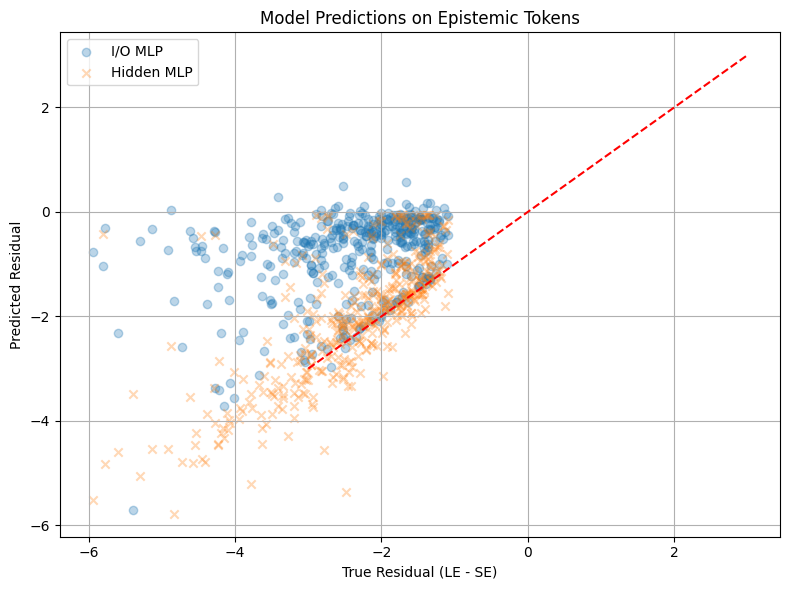

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Run analysis over N examples
df_long = analyze_token_predictions_batch(results, model, model_h, example_indices=range(500))

# Step 2: Filter only epistemically uncertain tokens (Label = 1)
df_epistemic = df_long[df_long["Label"] == 1]

# Optional: Further filter strong epistemic tokens
df_epistemic = df_epistemic[df_epistemic["TrueRes"].abs() > 1.0]

# Step 3: Print summary stats
print("\n=== Epistemic Token Analysis (Label = 1) ===")
print(f"Number of epistemic tokens: {len(df_epistemic)}")
print(f"Avg True Residual        : {df_epistemic['TrueRes'].mean():.3f}")
print(f"Avg I/O MLP Error        : {df_epistemic['Err_IO'].mean():.3f}")
print(f"Avg Hidden MLP Error     : {df_epistemic['Err_HID'].mean():.3f}")
io_wins = (df_epistemic["Err_IO"] < df_epistemic["Err_HID"]).mean() * 100
print(f"% Tokens where I/O MLP closer: {io_wins:.1f}%")

# Step 4: Show worst errors
print("\nTop 10 Hidden MLP misses:")
print(df_epistemic.sort_values("Err_HID", ascending=False).head(10)[
    ["Example", "Token", "TrueRes", "IO_MLP", "Hidden_MLP", "Err_IO", "Err_HID", "Closer"]
])

# Step 5: Scatter plot of model predictions vs true residuals
plt.figure(figsize=(8, 6))
plt.scatter(df_epistemic['TrueRes'], df_epistemic['IO_MLP'], alpha=0.3, label='I/O MLP', marker='o')
plt.scatter(df_epistemic['TrueRes'], df_epistemic['Hidden_MLP'], alpha=0.3, label='Hidden MLP', marker='x')
plt.plot([-3, 3], [-3, 3], 'r--')
plt.xlabel("True Residual (LE - SE)")
plt.ylabel("Predicted Residual")
plt.title("Model Predictions on Epistemic Tokens")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Run base analysis (if not already run)
df_long = analyze_token_predictions_batch(results, model, model_h, example_indices=range(500))

# Step 2: Filter only epistemically uncertain tokens
df_epistemic = df_long[
    (df_long["Label"] == 1) &
    (df_long["SE"] > 2.0) &
    (df_long["LE"] < 1.0)
]

# Step 3: From those, select tokens where I/O MLP fails to detect uncertainty
df_hidden_detected = df_epistemic[
    (df_epistemic["IO_MLP"].abs() < 0.5) &       # I/O model thinks it's not epistemic
    (df_epistemic["Hidden_MLP"].abs() > 1.0)     # Hidden MLP predicts strong residual
]

# Step 4: Show top such cases
print("\n=== Hidden detects epistemic uncertainty that I/O misses ===")
print(f"Count: {len(df_hidden_detected)}")
print(df_hidden_detected.sort_values("Hidden_MLP", ascending=False)[
    ["Example", "Token", "SE", "LE", "TrueRes", "IO_MLP", "Hidden_MLP", "Closer"]
].head(20))



Group: Label = 0
Tokens: 27423
Avg True Residual: -0.267
Avg I/O Error     : 0.408
Avg Hidden Error  : 0.321
% Tokens where I/O better: 44.7%

Group: Label = 1
Tokens: 409
Avg True Residual: -2.410
Avg I/O Error     : 1.591
Avg Hidden Error  : 0.590
% Tokens where I/O better: 18.6%

Pearson r (IO):     0.554
Pearson r (Hidden): 0.804

=== Hidden detects epistemic uncertainty that I/O misses ===
Count: 134
       Example       Token    SE    LE  TrueRes  IO_MLP  Hidden_MLP  Closer
12150      208  ĠMicrosoft  2.45  0.44    -2.01   -0.18       -1.02  Hidden
8556       159         Ġby  2.40  0.76    -1.64   -0.12       -1.03  Hidden
22026      402          Ġ(  2.11  0.36    -1.75   -0.39       -1.04  Hidden
10281      176           d  2.40  0.67    -1.73   -0.36       -1.04  Hidden
6692       126         Ġof  2.16  0.82    -1.34   -0.25       -1.05  Hidden
11810      203           ,  2.55  0.25    -2.29   -0.34       -1.13  Hidden
5972       114           -  2.17  0.93    -1.24   -0.14   

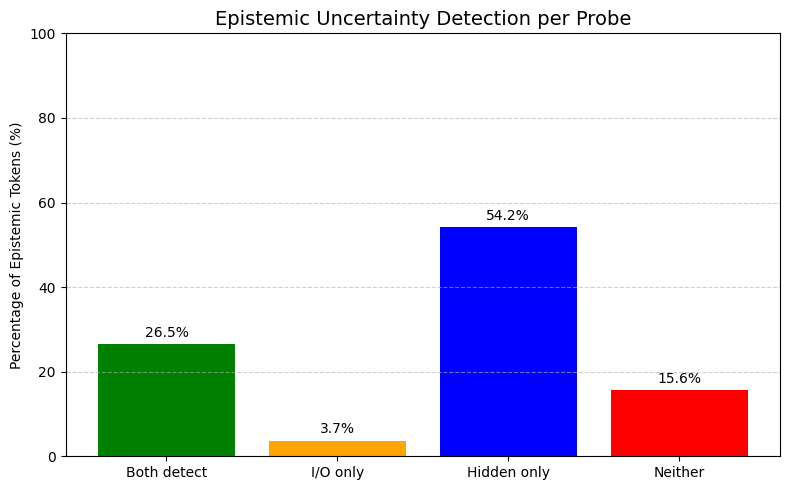

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Define case classification for each row
def classify_case(row):
    is_uncertain = row["Label"] == 1 and row["SE"] > 2.0 and row["LE"] < 1.0
    if not is_uncertain:
        return None
    io_detects = abs(row["IO_MLP"]) > 1.0
    hid_detects = abs(row["Hidden_MLP"]) > 1.0

    if io_detects and hid_detects:
        return "Both detect"
    elif io_detects and not hid_detects:
        return "I/O only"
    elif not io_detects and hid_detects:
        return "Hidden only"
    else:
        return "Neither"

# Step 2: Apply to dataframe
df_long["DetectionCase"] = df_long.apply(classify_case, axis=1)

# Step 3: Compute proportions
df_plot = (
    df_long["DetectionCase"]
    .value_counts(normalize=True)
    .mul(100)
    .reindex(["Both detect", "I/O only", "Hidden only", "Neither"])
    .fillna(0)
    .reset_index()
)
df_plot.columns = ["Case", "Percentage"]

# Step 4: Plot
colors = ["green", "orange", "blue", "red"]
plt.figure(figsize=(8, 5))
bars = plt.bar(df_plot["Case"], df_plot["Percentage"], color=colors)

plt.title("Epistemic Uncertainty Detection per Probe", fontsize=14)
plt.ylabel("Percentage of Epistemic Tokens (%)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Analyze a large batch
df_long_large = analyze_token_predictions_batch(results, model, model_h, example_indices=range(500))



Group: Label = 0
Tokens: 27423
Avg True Residual: -0.267
Avg I/O Error     : 0.408
Avg Hidden Error  : 0.321
% Tokens where I/O better: 44.7%

Group: Label = 1
Tokens: 409
Avg True Residual: -2.410
Avg I/O Error     : 1.591
Avg Hidden Error  : 0.590
% Tokens where I/O better: 18.6%

Pearson r (IO):     0.554
Pearson r (Hidden): 0.804


In [ ]:
def classify_case(row):
    is_uncertain = row["Label"] == 1 and row["SE"] > 2.0 and row["LE"] < 1.0
    if not is_uncertain:
        return None
    io_detects = abs(row["IO_MLP"]) > 1.0
    hid_detects = abs(row["Hidden_MLP"]) > 1.0

    if io_detects and hid_detects:
        return "Both detect"
    elif io_detects and not hid_detects:
        return "I/O only"
    elif not io_detects and hid_detects:
        return "Hidden only"
    else:
        return "Neither"

df_long_large["DetectionCase"] = df_long_large.apply(classify_case, axis=1)


In [ ]:
# Filter valid cases
df_valid = df_long_large[df_long_large["DetectionCase"].notna()]

# Count percentages
detection_props = df_valid["DetectionCase"].value_counts(normalize=True).mul(100).round(2)
print("Detection proportions (%):\n", detection_props)


Detection proportions (%):
 DetectionCase
Hidden only    54.21
Both detect    26.49
Neither        15.59
I/O only        3.71
Name: proportion, dtype: float64


In [ ]:
from scipy.stats import chi2_contingency

# Contingency Table: rows = [Detected, Not Detected], columns = [I/O, Hidden]
io_detect = df_valid["DetectionCase"].isin(["I/O only", "Both detect"]).sum()
io_miss   = df_valid["DetectionCase"].isin(["Hidden only", "Neither"]).sum()

hid_detect = df_valid["DetectionCase"].isin(["Hidden only", "Both detect"]).sum()
hid_miss   = df_valid["DetectionCase"].isin(["I/O only", "Neither"]).sum()

contingency = [[io_detect, io_miss],
               [hid_detect, hid_miss]]

chi2, p, dof, expected = chi2_contingency(contingency)

print("\nChi-Squared Test")
print("Contingency Table:")
print(f"I/O     - Detect: {io_detect}, Miss: {io_miss}")
print(f"Hidden  - Detect: {hid_detect}, Miss: {hid_miss}")
print(f"Chi² = {chi2:.3f}, p = {p:.5f}")



Chi-Squared Test
Contingency Table:
I/O     - Detect: 122, Miss: 282
Hidden  - Detect: 326, Miss: 78
Chi² = 206.454, p = 0.00000


In [ ]:
if p < 0.05:
    print("✅ Result: Statistically significant difference in detection rates.")
else:
    print("❌ Result: No significant difference.")


✅ Result: Statistically significant difference in detection rates.


In [ ]:
from tabulate import tabulate

def compare_token_predictions(idx, results, model_io, model_hid, device):
    ex = results[idx]

    tokens = ex["tokens"]
    input_ids = ex["input_ids"]
    topk_logits = ex["logits_topk"]
    hidden_states = ex["hidden_states"]
    true_residual = ex["residual"]
    label = ex["label"]
    se = ex["se"]
    le = ex["le"]

    # Filter out invalid token IDs (>= vocab size or < 0)
    valid_rows = []
    for i in range(len(input_ids)):
        if 0 <= input_ids[i] < model_io.embed.num_embeddings:
            valid_rows.append(i)

    # Convert to tensors only for valid tokens
    input_ids_tensor = torch.tensor([input_ids[i] for i in valid_rows], dtype=torch.long)
    topk_tensor = torch.tensor([topk_logits[i] for i in valid_rows], dtype=torch.float)
    hidden_tensor = torch.tensor([hidden_states[i] for i in valid_rows], dtype=torch.float)

    # Predict
    with torch.no_grad():
        pred_io = model_io(input_ids_tensor, topk_tensor).tolist()
        pred_hid = model_hid(hidden_tensor).tolist()

    # Build table
    table = []
    for j, i in enumerate(valid_rows):
        table.append([
            tokens[i],
            label[i],
            f"{se[i]:.2f}",
            f"{le[i]:.2f}",
            f"{true_residual[i]:+.2f}",
            f"{pred_io[j]:+.2f}",
            f"{pred_hid[j]:+.2f}"
        ])

    headers = ["Token", "Label", "SE", "LE", "TrueRes", "I/O_MLP", "Hidden_MLP"]
    print(tabulate(table, headers=headers, tablefmt="grid"))



In [ ]:
compare_token_predictions(42, results, model, model_h, device)


+-------------+---------+------+------+-----------+-----------+--------------+
| Token       |   Label |   SE |   LE |   TrueRes |   I/O_MLP |   Hidden_MLP |
+=============+=========+======+======+===========+===========+==============+
| Te          |       0 | 7.16 | 6.77 |     -0.39 |     -0.32 |        -0.54 |
+-------------+---------+------+------+-----------+-----------+--------------+
| chnology    |       0 | 6.35 | 6.12 |     -0.22 |     -0.2  |        -0.28 |
+-------------+---------+------+------+-----------+-----------+--------------+
| Ġcompany    |       0 | 6.31 | 6.48 |      0.17 |     -0.47 |        -0.06 |
+-------------+---------+------+------+-----------+-----------+--------------+
| Ġsu         |       1 | 2.33 | 0.67 |     -1.67 |     -1.19 |        -1.57 |
+-------------+---------+------+------+-----------+-----------+--------------+
| es          |       0 | 6.25 | 6.41 |      0.16 |     -0.35 |        -0.43 |
+-------------+---------+------+------+-----------+-

In [ ]:
from torch.utils.data import Dataset

class EntropyRegressionDataset(Dataset):
    def __init__(self, tokenizer, results):
        self.data = []
        for ex in results:
            token_ids = ex["input_ids"]
            entropies = ex["se"]

            if any(i >= tokenizer.vocab_size or i < 0 for i in token_ids):
                continue

            length = min(len(token_ids), len(entropies))
            if length == 0:
                continue

            self.data.append((
                torch.tensor(token_ids[:length], dtype=torch.long),
                torch.tensor(entropies[:length], dtype=torch.float)
            ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
import torch.nn as nn

class TokenEntropyMLP(nn.Module):
    def __init__(self, vocab_size, embed_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, input_ids):
        x = self.embed(input_ids)             # [B, T, D]
        out = self.mlp(x).squeeze(-1)         # [B, T]
        return out


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def collate(batch):
    ids, labels = zip(*batch)
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0.0)
    return ids, labels

dataset = EntropyRegressionDataset(tokenizer, results)
loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate)

model = TokenEntropyMLP(vocab_size=tokenizer.vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    model.train()
    total_loss = 0.0
    for input_ids, entropy_targets in tqdm(loader, desc=f"Epoch {epoch+1}"):
        input_ids = input_ids
        entropy_targets = entropy_target

        preds = model(input_ids)  # shape: [B, T]

        mask = (input_ids != tokenizer.pad_token_id)  # FIXED MASK
        loss = F.mse_loss(preds[mask], entropy_targets[mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}: MSE Loss = {avg_loss:.4f}")


Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]


NameError: name 'entropy_target' is not defined

In [ ]:
torch.save(model.state_dict(), "mlp_entropy_predictor.pt")
model.eval()

def visualize(text):
    input_ids = tokenizer(text, return_tensors="pt")["input_ids"].cuda()
    with torch.no_grad():
        pred_entropy = model(input_ids).squeeze(0).cpu()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    for tok, ent in zip(tokens, pred_entropy):
        print(f"{tok:15} | {ent.item():.2f}", flush=True)

# Try visualizing one of your training texts
visualize(texts[0])

In [ ]:
import torch.nn as nn
from transformers import AutoConfig

class EntropyTransformerProbe(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_layers=2, num_heads=4, max_len=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_len, embed_dim))  # Learnable position encodings
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Sequential(nn.Linear(embed_dim, 1), nn.Softplus())

    def forward(self, input_ids, attention_mask=None):
      x = self.embed(input_ids)
      if hasattr(self, 'pos_embed'):
          x = x + self.pos_embed[:, :x.size(1), :]
      x = self.encoder(x, src_key_padding_mask=~attention_mask.bool() if attention_mask is not None else None)
      return self.head(x).squeeze(-1)


In [ ]:
model_2 = EntropyTransformerProbe(vocab_size=tokenizer.vocab_size)
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)

for epoch in range(100):
    model_2.train()
    total_loss = 0.0

    for input_ids, entropy_targets in tqdm(loader, desc=f"Epoch {epoch+1}"):
        input_ids = input_ids
        entropy_targets = entropy_targets

        # Mask: True where tokens are not padding
        attention_mask = (input_ids != tokenizer.pad_token_id)

        # Forward pass with attention mask
        preds = model_2(input_ids, attention_mask=attention_mask)  # [B, T]

        # Compute loss only on non-padding tokens
        loss = F.mse_loss(preds[attention_mask], entropy_targets[attention_mask])

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}: MSE Loss = {avg_loss:.4f}")


Epoch 1:   0%|          | 0/1723 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
torch.save(model_2.state_dict(), "transformer_entropy_predictor.pt")
model_2.eval()

def visualize_2(text):
    input_ids = tokenizer(text, return_tensors="pt")["input_ids"].cuda()
    with torch.no_grad():
        pred_entropy = model_2(input_ids).squeeze(0).cpu()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    for tok, ent in zip(tokens, pred_entropy):
        print(f"{tok:15} | {ent.item():.2f}", flush=True)

# Try visualizing one of your training texts
visualize_2(texts[0])

In [ ]:
model.cpu()
model_2.cpu()
small_model.cpu()
large_model.cpu()

In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
example_text = "The mysterious figure stepped into the fog, unnoticed by the crowd."


In [ ]:
def get_true_entropy_cpu(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    with torch.no_grad():
        logits = small_model.to("cpu")(**inputs).logits
        probs = F.softmax(logits, dim=-1)
        true_entropy = compute_entropy(probs)[0, 1:]
    return true_entropy, inputs["input_ids"][0][1:]

In [ ]:
def get_mlp_entropy_cpu(input_ids):
    model.cpu()
    input_ids = input_ids.unsqueeze(0)  # [1, T]
    with torch.no_grad():
        preds = model(input_ids).squeeze(0)  # [T]
    return preds

def get_transformer_entropy_cpu(input_ids):
    model_2.cpu()
    input_ids = input_ids.unsqueeze(0)
    attention_mask = (input_ids != tokenizer.pad_token_id)
    with torch.no_grad():
        preds = model_2(input_ids, attention_mask=attention_mask).squeeze(0)
    return preds


In [ ]:
true_entropy, ids = get_true_entropy_cpu(example_text)
mlp_entropy = get_mlp_entropy_cpu(ids)
transformer_entropy = get_transformer_entropy_cpu(ids)

tokens = tokenizer.convert_ids_to_tokens(ids)

print(f"{'Token':15} | {'True':>6} | {'MLP':>6} | {'Transf':>6}")
print("-" * 45)
for tok, t, m, tr in zip(tokens, true_entropy, mlp_entropy, transformer_entropy):
    print(f"{tok:15} | {t.item():6.2f} | {m.item():6.2f} | {tr.item():6.2f}")


In [ ]:
def compare_with_epistemic_label(text, threshold_s=2.0, threshold_l=1.0):
    # 1. Compute true entropy from both models
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    input_ids = inputs["input_ids"][0][1:]  # skip BOS
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    with torch.no_grad():
        s_logits = small_model.to("cpu")(**inputs).logits
        l_logits = large_model.to("cpu")(**inputs).logits

        s_probs = F.softmax(s_logits, dim=-1)
        l_probs = F.softmax(l_logits, dim=-1)

        s_entropy = compute_entropy(s_probs)[0, 1:]
        l_entropy = compute_entropy(l_probs)[0, 1:]

    mlp_preds = get_mlp_entropy_cpu(input_ids)
    transf_preds = get_transformer_entropy_cpu(input_ids)

    print(f"{'Token':15} | {'S':>5} | {'L':>5} | {'Ep?'} | {'MLP':>5} | {'Transf':>6}")
    print("-" * 60)
    for tok, s, l, m, t in zip(tokens, s_entropy, l_entropy, mlp_preds, transf_preds):
        epistemic = s > threshold_s and l < threshold_l
        print(f"{tok:15} | {s.item():5.2f} | {l.item():5.2f} | {'✅' if epistemic else '  '}   | {m.item():5.2f} | {t.item():6.2f}")

In [ ]:
pip install termcolor


In [ ]:
from termcolor import colored
import torch.nn.functional as F

def print_colored_epistemic_tokens(text, s_thresh=2.0, l_thresh=1.0):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    input_ids = inputs["input_ids"][0][1:]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    with torch.no_grad():
        small_logits = small_model.to("cpu")(**inputs).logits
        large_logits = large_model.to("cpu")(**inputs).logits
        s_probs = F.softmax(small_logits, dim=-1)
        l_probs = F.softmax(large_logits, dim=-1)

        s_entropy = compute_entropy(s_probs)[0, 1:]
        l_entropy = compute_entropy(l_probs)[0, 1:]

    print("\nVisualized Sentence with Epistemic Highlights:\n")

    for tok, s, l in zip(tokens, s_entropy, l_entropy):
        word = tok.replace("Ġ", " ")
        if s > s_thresh and l < l_thresh:
            # Epistemically uncertain
            print(colored(word, "red", attrs=["bold"]), end="")
        elif s < 1.0:
            # Confident
            print(colored(word, "green"), end="")
        else:
            # Mid-level
            print(word, end="")
    print("\n")




In [ ]:
from IPython.display import HTML, display
import torch.nn.functional as F

def colored_html_entropy(text, s_thresh=2.0, l_thresh=1.0):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)
    input_ids = inputs["input_ids"][0][1:]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    with torch.no_grad():
        small_logits = small_model.to("cpu")(**inputs).logits
        large_logits = large_model.to("cpu")(**inputs).logits
        s_probs = F.softmax(small_logits, dim=-1)
        l_probs = F.softmax(large_logits, dim=-1)
        s_entropy = compute_entropy(s_probs)[0, 1:]
        l_entropy = compute_entropy(l_probs)[0, 1:]

    html = ""
    for tok, s, l in zip(tokens, s_entropy, l_entropy):
        word = tok.replace("Ġ", " ")
        if s > s_thresh and l < l_thresh:
            color = "#ff6666"  # red
        elif s < 1.0:
            color = "#66cc66"  # green
        else:
            color = "#cccccc"  # gray
        html += f'<span style="color:{color}; font-weight: bold;">{word}</span>'

    display(HTML(html))


In [ ]:
text = (
    "Despite repeated warnings from environmental scientists, the accelerated melting of polar ice caps "
    "continues to disrupt global weather patterns, with coastal cities bracing for rising sea levels and "
    "agricultural sectors facing unpredictable droughts and floods."
)

print_colored_epistemic_tokens(text)


In [ ]:
colored_html_entropy("Despite repeated warnings from environmental scientists, the accelerated melting of polar ice caps continues to disrupt global weather patterns, with coastal cities bracing for rising sea levels and agricultural sectors facing unpredictable droughts and floods.")
